In [6]:
import cv2
import os
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [62]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    print(data)
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def all_zeros(lst):
    return all(v == 0.0 for v in lst)


In [50]:
def extract_features(data,sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(data, sample_rate):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    # data, sample_rate = librosa.load(path)
    
    # without augmentation
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # # data with stretching and pitching
    # new_data = stretch(data)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    # res3 = extract_features(data_stretch_pitch,sample_rate)
    # result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
def detect_and_crop_face(frame, face_cascade):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    cropped_faces = [gray[y:y+h, x:x+w] for (x, y, w, h) in faces]
    return cropped_faces


face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
actorsId = ["{:02}".format(i) for i in range(1, 25)]
comboFiles = ['01-01-01', '01-01-02', '01-02-01', '01-02-02',
              '02-01-01', '02-01-02', '02-02-01', '02-02-02']

data = []
data_1 = []
# data_2 = []

for actor in actorsId:
    for emotion in range(1, 9):
        for file in comboFiles:
            try:
                path = f"Dataset/Actor_{actor}/01-01-0{emotion}-{file}-{actor}.mp4"
                y, sr = librosa.load(path, sr=None)


                cap = cv2.VideoCapture(path)
                frame_rate = cap.get(cv2.CAP_PROP_FPS)
                frame_count = 0

                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    cropped_frame = detect_and_crop_face(frame, face_cascade)
                    if cropped_frame:
                        compressedFrame = cv2.resize(
                            cropped_frame[0], (128, 128), interpolation=cv2.INTER_CUBIC)

                        # Calculating the audio segment for this frame
                        start_sample = int(frame_count * sr / frame_rate)
                        end_sample = int((frame_count + 1) * sr / frame_rate)
                        audio_segment = y[start_sample:end_sample]
                        if(all_zeros(audio_segment)!=True):
                            metaData = file.split('-')

                            features = get_features(audio_segment, sr)
                            regular_features, noise_features = features

                            data.append({
                                "vid id":f"01-01-0{emotion}-{file}-{actor}",
                                "frame count": frame_count,
                                "frame": compressedFrame,
                                "audio": audio_segment,
                                "audio features": regular_features,
                                "actor": actor,
                                "emotion": emotion,
                                "emotional intensity": metaData[0],
                                "statement": metaData[1],
                                "repetition": metaData[2],
                                "noise":False
                            })

                            # Add the noise data
                            data_1.append({
                                "vid id":f"01-01-0{emotion}-{file}-{actor}",
                                "frame count": frame_count,
                                "frame": compressedFrame,
                                "audio": noise(audio_segment),
                                "audio features": noise_features,
                                "actor": actor,
                                "emotion": emotion,
                                "emotional intensity": metaData[0],
                                "statement": metaData[1],
                                "repetition": metaData[2],
                                "noise":True
                            })

                            # # Add the stretched data
                            # data_2.append({
                            #     "frame count": frame_count,
                            #     "frame": compressedFrame,
                            #     "audio": stretch(audio_segment),
                            #     "extracted_features": stretch_features,
                            #     "actor": actor,
                            #     "emotion": emotion,
                            #     "Emotional intensity": metaData[0],
                            #     "Statement": metaData[1],
                            #     "Repetition": metaData[2]
                            # })

                            frame_count += 1

            except Exception as e:
                print(f"Error processing {path}: {e}")

# Combine the lists and convert to a pandas dataframe
df = pd.DataFrame(data + data_1)


In [81]:
df

,vid id,frame count,frame,audio,audio features,actor,emotion,emotional intensity,statement,repetition,noise
0,01-01-01-01-02-01-01,0,"[[253, 253, 253, 253, 253, 253, 253, 253, 247,...","[-3.0517578e-05, -3.0517578e-05, -3.0517578e-0...","[0.01220703125, 0.812852680683136, 0.812012791...",01,1,01,02,01,False
1,01-01-01-01-02-01-01,1,"[[253, 253, 253, 253, 253, 253, 253, 253, 252,...","[-6.1035156e-05, -6.1035156e-05, -6.1035156e-0...","[0.0059814453125, 0.8630922436714172, 0.868914...",01,1,01,02,01,False
2,01-01-01-01-02-01-01,2,"[[253, 253, 253, 253, 253, 253, 253, 253, 253,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.003662109375, 0.9270709156990051, 0.8422607...",01,1,01,02,01,False
3,01-01-01-01-02-01-01,3,"[[253, 253, 253, 253, 253, 253, 253, 253, 253,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0045166015625, 0.8452808856964111, 0.848675...",01,1,01,02,01,False
4,01-01-01-01-02-01-01,4,"[[253, 253, 253, 253, 253, 253, 253, 253, 253,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0174560546875, 0.702946126461029, 0.8371542...",01,1,01,02,01,False
...,...,...,...,...,...,...,...,...,...,...,...
104035,01-01-04-02-01-01-24,13,"[[254, 253, 255, 133, 42, 37, 58, 81, 114, 21,...","[-1.579191743511708e-05, 3.4123348578448256e-0...","[0.2039794921875, 0.7962486468041126, 0.560886...",24,4,02,01,01,True
104036,01-01-04-02-01-01-24,14,"[[253, 253, 253, 217, 97, 39, 43, 49, 83, 102,...","[-1.0781466245691322e-07, -1.3642225719464066e...","[0.2108154296875, 0.907629627409263, 0.8048982...",24,4,02,01,01,True
104037,01-01-04-02-01-01-24,15,"[[254, 253, 252, 158, 42, 35, 55, 66, 112, 28,...","[3.081305060366245e-05, 3.0667018999773796e-05...","[0.259033203125, 0.8863280797580614, 0.8850824...",24,4,02,01,01,True
104038,01-01-04-02-01-01-24,16,"[[253, 253, 254, 253, 228, 94, 40, 43, 59, 73,...","[3.971169657236112e-07, 8.669406427239783e-07,...","[0.2774658203125, 0.8669556931571607, 0.861406...",24,4,02,01,01,True


In [ ]:
# # Split the 'file' column
# df[['Emotional intensity', 'Statement', 'Repetition']] = df['file'].str.split('-', expand=True)

# # Drop the original 'file' column
# df.drop(columns=['file'], inplace=True)


In [215]:
df.to_pickle("aligned_data.pkl")

In [2]:
df = pd.read_pickle("aligned_data.pkl")

In [5]:
df

,vid id,frame count,frame,audio,audio features,actor,emotion,emotional intensity,statement,repetition,noise
0,01-01-01-01-02-01-01,0,"[[253, 253, 253, 253, 253, 253, 253, 253, 247,...","[-3.0517578e-05, -3.0517578e-05, -3.0517578e-0...","[0.01220703125, 0.812852680683136, 0.812012791...",01,1,01,02,01,False
1,01-01-01-01-02-01-01,1,"[[253, 253, 253, 253, 253, 253, 253, 253, 252,...","[-6.1035156e-05, -6.1035156e-05, -6.1035156e-0...","[0.0059814453125, 0.8630922436714172, 0.868914...",01,1,01,02,01,False
2,01-01-01-01-02-01-01,2,"[[253, 253, 253, 253, 253, 253, 253, 253, 253,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.003662109375, 0.9270709156990051, 0.8422607...",01,1,01,02,01,False
3,01-01-01-01-02-01-01,3,"[[253, 253, 253, 253, 253, 253, 253, 253, 253,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0045166015625, 0.8452808856964111, 0.848675...",01,1,01,02,01,False
4,01-01-01-01-02-01-01,4,"[[253, 253, 253, 253, 253, 253, 253, 253, 253,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0174560546875, 0.702946126461029, 0.8371542...",01,1,01,02,01,False
...,...,...,...,...,...,...,...,...,...,...,...
104035,01-01-04-02-01-01-24,13,"[[254, 253, 255, 133, 42, 37, 58, 81, 114, 21,...","[-1.579191743511708e-05, 3.4123348578448256e-0...","[0.2039794921875, 0.7962486468041126, 0.560886...",24,4,02,01,01,True
104036,01-01-04-02-01-01-24,14,"[[253, 253, 253, 217, 97, 39, 43, 49, 83, 102,...","[-1.0781466245691322e-07, -1.3642225719464066e...","[0.2108154296875, 0.907629627409263, 0.8048982...",24,4,02,01,01,True
104037,01-01-04-02-01-01-24,15,"[[254, 253, 252, 158, 42, 35, 55, 66, 112, 28,...","[3.081305060366245e-05, 3.0667018999773796e-05...","[0.259033203125, 0.8863280797580614, 0.8850824...",24,4,02,01,01,True
104038,01-01-04-02-01-01-24,16,"[[253, 253, 254, 253, 228, 94, 40, 43, 59, 73,...","[3.971169657236112e-07, 8.669406427239783e-07,...","[0.2774658203125, 0.8669556931571607, 0.861406...",24,4,02,01,01,True


In [6]:
min_length = df['audio features'].apply(len).min()
max_length = df['audio features'].apply(len).max()

print("Minimum length:", min_length)
print("Maximum length:", max_length)

Minimum length: 162
Maximum length: 162


In [7]:
min_length = df['audio'].apply(len).min()
max_length = df['audio'].apply(len).max()

print("Minimum length:", min_length)
print("Maximum length:", max_length)

Minimum length: 1096
Maximum length: 1602


In [8]:
df['frame count'].max()

148

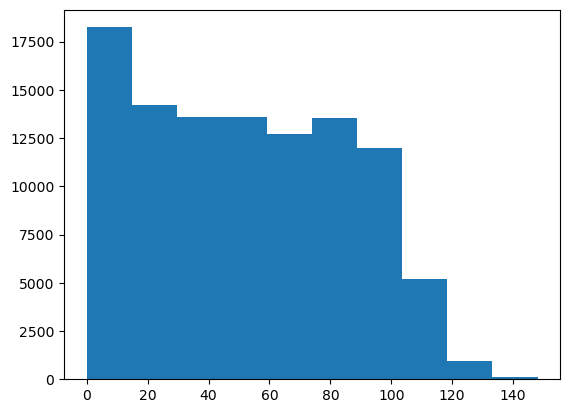

In [8]:
counts, bin_edges, _ = plt.hist(np.array(df['frame count']), bins=10)

In [10]:
bin_edges

array([  0. ,  14.8,  29.6,  44.4,  59.2,  74. ,  88.8, 103.6, 118.4,
       133.2, 148. ])

In [9]:
# Split the dataframe based on the 'Repetition' column
df_01 = df[df['repetition'] == '01']
df_02 = df[df['repetition'] == '02']


In [12]:
df_01

,vid id,frame count,frame,audio,audio features,actor,emotion,emotional intensity,statement,repetition,noise
0,01-01-01-01-02-01-01,0,"[[253, 253, 253, 253, 253, 253, 253, 253, 247,...","[-3.0517578e-05, -3.0517578e-05, -3.0517578e-0...","[0.01220703125, 0.812852680683136, 0.812012791...",01,1,01,02,01,False
1,01-01-01-01-02-01-01,1,"[[253, 253, 253, 253, 253, 253, 253, 253, 252,...","[-6.1035156e-05, -6.1035156e-05, -6.1035156e-0...","[0.0059814453125, 0.8630922436714172, 0.868914...",01,1,01,02,01,False
2,01-01-01-01-02-01-01,2,"[[253, 253, 253, 253, 253, 253, 253, 253, 253,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.003662109375, 0.9270709156990051, 0.8422607...",01,1,01,02,01,False
3,01-01-01-01-02-01-01,3,"[[253, 253, 253, 253, 253, 253, 253, 253, 253,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0045166015625, 0.8452808856964111, 0.848675...",01,1,01,02,01,False
4,01-01-01-01-02-01-01,4,"[[253, 253, 253, 253, 253, 253, 253, 253, 253,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0174560546875, 0.702946126461029, 0.8371542...",01,1,01,02,01,False
...,...,...,...,...,...,...,...,...,...,...,...
104035,01-01-04-02-01-01-24,13,"[[254, 253, 255, 133, 42, 37, 58, 81, 114, 21,...","[-1.579191743511708e-05, 3.4123348578448256e-0...","[0.2039794921875, 0.7962486468041126, 0.560886...",24,4,02,01,01,True
104036,01-01-04-02-01-01-24,14,"[[253, 253, 253, 217, 97, 39, 43, 49, 83, 102,...","[-1.0781466245691322e-07, -1.3642225719464066e...","[0.2108154296875, 0.907629627409263, 0.8048982...",24,4,02,01,01,True
104037,01-01-04-02-01-01-24,15,"[[254, 253, 252, 158, 42, 35, 55, 66, 112, 28,...","[3.081305060366245e-05, 3.0667018999773796e-05...","[0.259033203125, 0.8863280797580614, 0.8850824...",24,4,02,01,01,True
104038,01-01-04-02-01-01-24,16,"[[253, 253, 254, 253, 228, 94, 40, 43, 59, 73,...","[3.971169657236112e-07, 8.669406427239783e-07,...","[0.2774658203125, 0.8669556931571607, 0.861406...",24,4,02,01,01,True


In [13]:
df_02

,vid id,frame count,frame,audio,audio features,actor,emotion,emotional intensity,statement,repetition,noise
7,01-01-01-01-02-02-01,0,"[[253, 253, 253, 253, 253, 253, 253, 253, 253,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.013427734375, 0.8067516684532166, 0.6278198...",01,1,01,02,02,False
8,01-01-01-01-02-02-01,1,"[[253, 253, 253, 253, 253, 253, 253, 253, 250,...","[3.0517578e-05, 3.0517578e-05, 0.0, 0.0, 0.0, ...","[0.017578125, 0.8443632125854492, 0.6804057359...",01,1,01,02,02,False
9,01-01-01-01-02-02-01,2,"[[253, 253, 253, 253, 253, 253, 253, 252, 229,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0234375, 0.702118992805481, 0.6446371674537...",01,1,01,02,02,False
10,01-01-01-01-02-02-01,3,"[[253, 253, 253, 253, 253, 253, 253, 253, 246,...","[0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3.051757...","[0.018310546875, 0.8516716957092285, 0.8135567...",01,1,01,02,02,False
11,01-01-01-01-02-02-01,4,"[[253, 253, 253, 253, 253, 253, 253, 252, 238,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.051...","[0.01318359375, 0.7413109540939331, 0.79071688...",01,1,01,02,02,False
...,...,...,...,...,...,...,...,...,...,...,...
104015,01-01-08-02-01-02-23,1,"[[249, 246, 245, 244, 243, 235, 229, 227, 123,...","[-3.116847260855503e-05, -2.9432683315599703e-...","[0.3057861328125, 0.9521885992410819, 0.992643...",23,8,02,01,02,True
104016,01-01-08-02-02-02-23,0,"[[247, 246, 245, 244, 239, 239, 238, 190, 59, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.000732421875, 0.7256540189050282, 0.7223903...",23,8,02,02,02,True
104017,01-01-08-02-02-02-23,1,"[[249, 246, 246, 244, 243, 237, 233, 191, 45, ...","[1.6726869329313697e-07, 7.980896518199207e-08...","[0.3189697265625, 0.7662550400594264, 0.822581...",23,8,02,02,02,True
104018,01-01-08-02-02-02-23,2,"[[249, 246, 246, 244, 244, 235, 236, 223, 89, ...","[7.155166123831925e-07, -1.8757600037796739e-0...","[0.2032470703125, 0.8972199320925334, 0.784109...",23,8,02,02,02,True


# Main Model
================================================================================================================================================================================
================================================================================================================================================================================

3, 15, 224, 224

In [1]:
import tensorflow as tf

# Custom Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")        
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        at = tf.keras.backend.softmax(et)
        at = tf.keras.backend.repeat_elements(at, x.shape[-1], axis=2)
        output = x * at
        return tf.keras.backend.sum(output, axis=1)

# CNNs for Audio
audio_input = tf.keras.layers.Input(shape=(149,162))
audio_model = tf.keras.layers.Conv1D(128, kernel_size=5, strides=1, padding='same',  activation='relu')(audio_input)
audio_model = tf.keras.layers.MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(audio_model)
audio_model = tf.keras.layers.Conv1D(64, kernel_size=5, strides=1, padding='same',  activation='relu')(audio_model)
audio_model = tf.keras.layers.MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(audio_model)
audio_model = tf.keras.layers.Dropout(0.2)(audio_model)
audio_model = tf.keras.layers.Conv1D(32, kernel_size=5, strides=1, padding='same',  activation='relu')(audio_model)
audio_model = tf.keras.layers.MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(audio_model)

# CNNs for Video
video_input = tf.keras.layers.Input(shape=(149,128,128,1))
video_model = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))(video_input)
video_model = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))(video_model)
video_model = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))(video_model)
video_model = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))(video_model)
video_model = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2))(video_model)
video_model = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))(video_model)
video_model = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))(video_model)
video_model = tf.keras.layers.MaxPooling3D(pool_size=(8, 1, 1), strides=(8, 1, 1), padding='same')(video_model)
video_model = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(video_model)

# Combine audio and video features
combined = tf.keras.layers.concatenate([audio_model, video_model])

# RNN with LSTM and Attention
lstm_out = tf.keras.layers.LSTM(128, return_sequences=True)(combined)
attention_output = AttentionLayer()(lstm_out)

# MLP for Classification
x = tf.keras.layers.Dense(64, activation='relu')(attention_output)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(8, activation='softmax')(x)

# Compile and Train
model = tf.keras.models.Model(inputs=[audio_input, video_input], outputs=output)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-10-11 10:05:54.323871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-11 10:05:54.324039: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 149, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 time_distributed (TimeDistribu  (None, 149, 126, 12  1280       ['input_2[0][0]']                
 ted)                           6, 128)                                                           
                                                                                                  
 input_1 (InputLayer)           [(None, 149, 162)]   0           []                               
                                                                                              

In [4]:
import pydotplus
from tensorflow.keras.utils import model_to_dot

dot = model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60)
graph = pydotplus.graph_from_dot_data(dot.to_string())
graph.write_png('model_plot.png')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


AttributeError: 'NoneType' object has no attribute 'to_string'

In [17]:
df[['audio features', 'frame']]

,audio features,frame
0,"[0.01220703125, 0.812852680683136, 0.812012791...","[[253, 253, 253, 253, 253, 253, 253, 253, 247,..."
1,"[0.0059814453125, 0.8630922436714172, 0.868914...","[[253, 253, 253, 253, 253, 253, 253, 253, 252,..."
2,"[0.003662109375, 0.9270709156990051, 0.8422607...","[[253, 253, 253, 253, 253, 253, 253, 253, 253,..."
3,"[0.0045166015625, 0.8452808856964111, 0.848675...","[[253, 253, 253, 253, 253, 253, 253, 253, 253,..."
4,"[0.0174560546875, 0.702946126461029, 0.8371542...","[[253, 253, 253, 253, 253, 253, 253, 253, 253,..."
...,...,...
104035,"[0.2039794921875, 0.7962486468041126, 0.560886...","[[254, 253, 255, 133, 42, 37, 58, 81, 114, 21,..."
104036,"[0.2108154296875, 0.907629627409263, 0.8048982...","[[253, 253, 253, 217, 97, 39, 43, 49, 83, 102,..."
104037,"[0.259033203125, 0.8863280797580614, 0.8850824...","[[254, 253, 252, 158, 42, 35, 55, 66, 112, 28,..."
104038,"[0.2774658203125, 0.8669556931571607, 0.861406...","[[253, 253, 254, 253, 228, 94, 40, 43, 59, 73,..."


In [1]:
# Constant
MAX_FRAMES = 149

def pad_sequences(df):
    grouped = df.groupby(['vid id', 'noise'])

    padded_audios = []
    padded_videos = []
    labels = []

    for name, group in grouped:
        group = group.sort_values(by=['frame count'])

        audio_data = group['audio features'].tolist()
        video_data = group['frame'].tolist()

        # Pad sequences for audio and video data
        audio_padding_amount = MAX_FRAMES - len(audio_data)
        video_padding_amount = MAX_FRAMES - len(video_data)

        audio_data.extend([np.zeros((162,)) for _ in range(audio_padding_amount)])
        video_data.extend([np.zeros((128, 128)) for _ in range(video_padding_amount)])

        # Adjust the label value based on 'emotional intensity'
        label = np.zeros(8)  # 8 classes
        emotion = group['emotion'].iloc[0] - 1  # Assuming emotions are 1-8, we subtract 1 to get 0-based index
        intensity_factor = 0.5 if group['emotional intensity'].iloc[0] == '01' else 1.0

        label[emotion] = intensity_factor

        padded_audios.append(np.array(audio_data))
        padded_videos.append(np.array(video_data))
        labels.append(label)

    print("Shapes before final conversion:")
    print(np.shape(padded_audios))
    print(np.shape(padded_videos))

    return np.array(padded_audios), np.array(padded_videos), np.array(labels)



In [19]:
# Train
padded_audios_train, padded_videos_train, labels_train = pad_sequences(df_02)


Shapes before final conversion:
(790, 149, 162)
(790, 149, 128, 128)


In [20]:
# Test val
padded_audios, padded_videos, labels = pad_sequences(df_01)

Shapes before final conversion:
(804, 149, 162)
(804, 149, 128, 128)


In [21]:
# from tensorflow.keras import backend as K
# K.clear_session()

In [22]:

# Split data into training and validation sets
(X_test_audio, X_val_audio, 
 X_test_video, X_val_video, 
 y_test, y_val) = train_test_split(padded_audios, padded_videos, labels, 
                                    test_size=0.5, random_state=42)

In [24]:
history = model.fit([padded_audios_train, padded_videos_train], labels_train, epochs=6, batch_size=13, validation_data=([X_val_audio, X_val_video], y_val))

Epoch 1/6
61/61 [==============================] - ETA: 0s - loss: 2.8580 - accuracy: 0.2000

2023-10-10 14:40:49.046164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-10 14:40:51.363622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 496s 8s/step - loss: 2.8580 - accuracy: 0.2000 - val_loss: 2.6776 - val_accuracy: 0.1418
Epoch 2/6
61/61 [==============================] - 493s 8s/step - loss: 5.8162 - accuracy: 0.2101 - val_loss: 2.9802 - val_accuracy: 0.1169
Epoch 3/6
61/61 [==============================] - 495s 8s/step - loss: 9.2517 - accuracy: 0.1797 - val_loss: 6.3455 - val_accuracy: 0.1219
Epoch 4/6
61/61 [==============================] - 488s 8s/step - loss: 12.4061 - accuracy: 0.1633 - val_loss: 6.6870 - val_accuracy: 0.1418
Epoch 5/6
61/61 [==============================] - 490s 8s/step - loss: 14.4640 - accuracy: 0.1532 - val_loss: 9.3443 - val_accuracy: 0.1318
Epoch 6/6
61/61 [==============================] - 491s 8s/step - loss: 16.9401 - accuracy: 0.1557 - val_loss: 14.6045 - val_accuracy: 0.1219


In [ ]:
history = model.fit([padded_audios_train, padded_videos_train], labels_train, epochs=79, batch_size=10, validation_data=([X_val_audio, X_val_video], y_val))

In [31]:
history.history['val_loss']

[2.677579164505005,
 2.980215311050415,
 6.345480918884277,
 6.686970233917236,
 9.34427547454834,
 14.604469299316406]

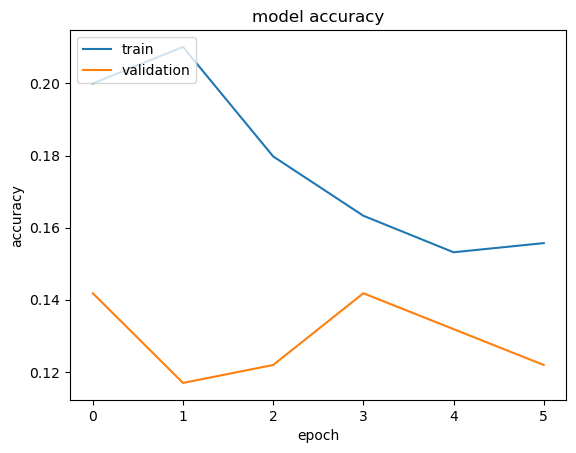

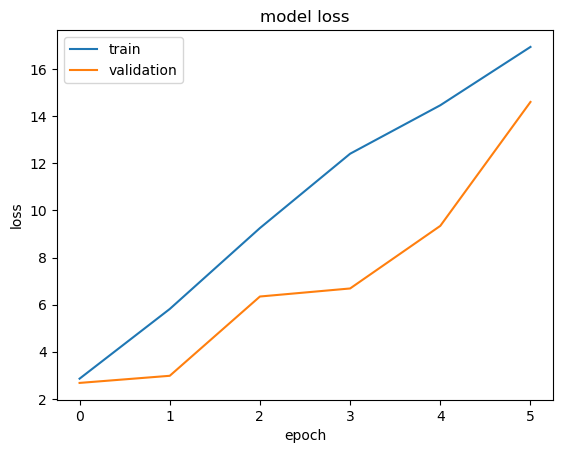

In [25]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [26]:
# Assuming you have already prepared your test set in the same way as your training set
# padded_audios_test and padded_videos_test are the audio and video data of your test set
# labels_test are the true labels of your test set

# Predict the emotions on test data
predictions = model.predict([X_test_audio, X_test_video])
predicted_labels = np.argmax(predictions, axis=1)

# If your labels_test are not one-hot encoded, skip this line
true_labels = np.argmax(y_test, axis=1)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Model Accuracy on Test Set: {accuracy * 100:.2f}%')


2023-10-10 15:23:01.383202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


ResourceExhaustedError: Graph execution error:

Detected at node 'model/time_distributed/conv2d/Conv2D' defined at (most recent call last):
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/zj/hd8_xvbd3fvbp9wj5412cw_c0000gn/T/ipykernel_99374/1532747144.py", line 6, in <module>
      predictions = model.predict([X_test_audio, X_test_video])
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/layers/rnn/time_distributed.py", line 221, in call
      y = self.layer(inputs, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'model/time_distributed/conv2d/Conv2D'
Detected at node 'model/time_distributed/conv2d/Conv2D' defined at (most recent call last):
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/zj/hd8_xvbd3fvbp9wj5412cw_c0000gn/T/ipykernel_99374/1532747144.py", line 6, in <module>
      predictions = model.predict([X_test_audio, X_test_video])
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/layers/rnn/time_distributed.py", line 221, in call
      y = self.layer(inputs, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'model/time_distributed/conv2d/Conv2D'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[4768,126,126,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator Simple allocator
	 [[{{node model/time_distributed/conv2d/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[model/time_distributed_6/Reshape_1/_6]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[4768,126,126,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator Simple allocator
	 [[{{node model/time_distributed/conv2d/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_8772]